In [12]:
import lalsimulation
import lal
import bilby
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from pycbc.filter.matchedfilter import optimized_match
from scipy.optimize import minimize
import matplotlib.tri as tri
from scipy.integrate import odeint
import scipy as sp
import seaborn as sns
%matplotlib inline

In [13]:
lalsimulation?

Type:        module
String form: <module 'lalsimulation' from '/home/williams5/testing_urs/lalsuite/_inst/lib/python3.11/site-packages/lalsimulation/__init__.py'>
File:        ~/testing_urs/lalsuite/_inst/lib/python3.11/site-packages/lalsimulation/__init__.py
Docstring:   <no docstring>

In [14]:
#Matplotlib Parameters
plt.rcParams['axes.linewidth'] = 1.75

rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 24,
             'legend.fontsize': 18,
             'xtick.labelsize': 18,
             'ytick.labelsize': 18,
             'font.family': 'serif',
             'mathtext.fontset': 'cm',         # Use Computer Modern math fonts (LaTeX style)
             'mathtext.rm': 'serif',  
             #'font.sans-serif': ['Bitstream Vera Sans'],
             #'font.serif': ['Times New Roman'],
             #'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}',
             #'text.usetex':False,
             'lines.linewidth': 3
            }

plt.rcParams["patch.force_edgecolor"] = True

plt.rcParams.update(rc_params)

In [15]:
def easy_match(fs,h1,h2,psd_function,zero_pad_factor=3):
    '''
        Light weight wrapper to calculate the match between
        two FD waveforms h1 and h2. See match calculation in Mathematica.

        Agrees with pycbc match function.
    '''
    if(len(h1) != len(h2)):
        raise Exception('Error: length of h1 and h2 do not match!')
    #if not(is_uniformly_sampled(fs)):
    #    raise Exception('Error: frequencies are not uniformly sampled.')

    length       = len(h1)

    # Here, psd_function(100) multiplies everything by some term \alpha
    # which cancels at the end. This is just used for data conditioning.
    Sn_array     = psd_function(100) / np.array( list( map(psd_function, fs) ) )
    Sn_array[-1] = Sn_array[-2]

    Ah1          = np.abs(h1)
    Ah2          = np.abs(h2)
    norm1        = np.dot(Ah1, Ah1 * Sn_array)
    norm2        = np.dot(Ah2, Ah2 * Sn_array)

    # Get the integrand
    integrand    = h1 * h2.conj() * Sn_array

    # Zero pad the integrand
    integrand_zp = np.pad(integrand,(0,zero_pad_factor * length),'constant',constant_values=(0,0))

    # Get the complex snr
    complex_snr  = np.asarray( np.fft.fft(integrand_zp) )
    match        = np.max(np.abs(complex_snr)) / np.sqrt(norm1 * norm2)

    return match


def get_mismatch(f, h1, h2, flow, fhigh, method = None):
    idx = (f>flow) * (f<fhigh)
    # apply band
    _f = f[idx]
    h1_norm = h1[idx]
    h2_norm = h2[idx]
    # normalize h1 and h2
    h1_norm /= np.sqrt(dot(_f, h1_norm, h1_norm))
    h2_norm /= np.sqrt(dot(_f, h2_norm, h2_norm))
    # maximize overlap by linear offset in f
    if method == None:
      method = ["Nelder-Mead", "Powell", "CG", "BFGS", "TNC", "L-BFGS-B", "COBYLA", "SLSQP"]
      #method = ["Nelder-Mead", "Powell", "CG", "BFGS"]
    else:
        method = [method]

    def _mismatch(c):
        mismatch = 1.-dot(_f, h1_norm, h2_norm*np.exp(+1j*(c[0]+c[1]*2.*np.pi*_f)))
        return mismatch

    minmismatch = 1.0
    count = 5
    counter = 0
    cguess  = np.array([0.,0.])    
    #off = [0,0.0001,0.002,0.005,0.005,0.1,0.5,1.0,2.,3.,10]

    while minmismatch > 1e-2 and counter <= count:
        result_mismatch = []
        for imethod in method:
            res = minimize(_mismatch, cguess, method = imethod)
            result_mismatch.append(_mismatch(res.x))
        cguess = cguess + 0.02
        #print(cguess)
        minmismatch = np.min(result_mismatch)
        counter = counter + 1.  
        #print(minmismatch)

    indexmin = result_mismatch.index(minmismatch)
    method_used = method[indexmin]
    return minmismatch, method_used

def dot(f, h1, h2):
    df = f[1]-f[0]
    result = np.real(4.*df*np.nansum(np.conjugate(h1)*h2/1))
    return result

def get_quadrupole(EOS, m, chi):
    c = 299792458.
    G = 6.6743015e-11
    Msun = 1.9891e30

    GR_CM2_fac = 1e-7
    RNS_Q_FAC = 1e42
    GEOM_FAC = c**4/G**2
    if EOS =='stiff':
        Q = 568.011*m*chi**2 - 335.63*chi**3 + 62.3359*m**2*chi**3
    elif EOS == 'soft':
        Q = 507.293*m*chi**2 - 44.8039*m**3*chi**2 - 378.495*chi**3 + 315.377*m*chi**3
    return Q*RNS_Q_FAC*GR_CM2_fac*GEOM_FAC/(m*Msun)**3/(chi**2)

def get_f2_from_Lambda_UR_SI(Lambda, M):
    '''
    Calculates (quadrupolar) f-mode frequency though UR as in Sotani & Kumar (2021)
    https://arxiv.org/pdf/2109.08145
    
    Inputs:
    Lambda - (quadrupolar) Dimensionless tidal deformability
    M - Mass [Solar Masses]

    Outputs:
    f-mode frequency [Hz]
    '''
    g = [4.2590, -0.47874, -0.45353, 0.14439, -0.016194, 0.00064163]
    UR = 0.
    for i ,g_i in enumerate(g):
        UR+=g_i*(np.log10(Lambda))**i
    return UR*(1.4/M)*1000

In [16]:
def omega2(Lambda, MAarray):
    avalues = [4.2590, -0.47874, -0.45353,  0.14439, -0.016194, 0.00064163]
    if Lambda < 0:
        return print('error')
    else:
        x = np.log10(Lambda)
        val = avalues[0] + avalues[1]*x + avalues[2]*x**2. + avalues[3]*x**3. + avalues[4]*x**4. + avalues[5]*x**5.
        return val*(1.4/MAarray)*1000*2*np.pi/cs*Msol*Grav*cs**(-2.)

def derivativematrix(inputmatrix, withrespecttomatrix, order):
    der = [];
    if order == 1:
        for i in range(0, len(inputmatrix)):
            der1 = np.gradient(inputmatrix[i], withrespecttomatrix[i])
            der.append(der1)
    elif order == 2:
        for i in range(0, len(inputmatrix)):
            der1 = np.gradient(inputmatrix[i], withrespecttomatrix[i])
            der2 = np.gradient(der1, withrespecttomatrix[i])
            der.append(der2)
    return np.asarray(der)

def Extract_keff(phiTPNmatrix_dyn, psiTPNmatrix_const, withrespecttomatrix):
    #Calculate kbar as in eq 25
    dphimatrix = derivativematrix(phiTPNmatrix_dyn, withrespecttomatrix, 1); #dphi/domegahat
    dpsimatrix = derivativematrix(psiTPNmatrix_const, withrespecttomatrix, 1); #dpsi/domegahat
    ddpsimatrix = derivativematrix(psiTPNmatrix_const, withrespecttomatrix, 2); #d^2 psi/domegahat^2
    result = []
    xmatrix = []
    def dU_dx(U, freq):
        #Function to solve with odeint U[0] = kbar, U[1]=dkbar/domegahat, retursn derivatives of both
        return [U[1], ((1/freq)*dphiinterpolant(freq) - 2*U[1]*dpsiinterpolant(freq) - U[0]*ddpsiinterpolant(freq))/(psiinterpolant(freq))]
    for i in range(0, len(phiTPNmatrix_dyn)):
        #Create inerpolant fot all derivatives
        psiinterpolant = sp.interpolate.interp1d(withrespecttomatrix[i], psiTPNmatrix_const[i], fill_value = 'extrapolate')
        dphiinterpolant = sp.interpolate.interp1d(withrespecttomatrix[i], dphimatrix[i], fill_value = 'extrapolate')
        dpsiinterpolant = sp.interpolate.interp1d(withrespecttomatrix[i], dpsimatrix[i], fill_value = 'extrapolate')
        ddpsiinterpolant = sp.interpolate.interp1d(withrespecttomatrix[i], ddpsimatrix[i], fill_value = 'extrapolate')
        U0 = [1., 0.] #initial conditions
        xs = np.linspace(0.000018, withrespecttomatrix[i][-1], 4000) #input x array
        Us = odeint(dU_dx, U0, xs) #solve
        ys = Us[:,0] #obtain keff
        result.append(ys)
        xmatrix.append(xs)
    return np.asarray(xmatrix), np.asarray(result)

#Dynamical Tides: (the following functions below can be used to obtain arrays)
def t_hat(omegaorb, epsilon, omega_02):
    that = (8./(5.*np.sqrt(epsilon)))*(1 - (omega_02/(2*omegaorb))**(5./3.))
    return that
def Q_ll(omegaorb, epsilon, omega_02): 
    Qval = np.cos(np.abs(Omegaprime)*t_hat(omegaorb, epsilon, omega_02)**2.)*(1./(2.*np.sqrt(np.abs(Omegaprime))))*np.sqrt(np.pi/2)*(1+2*sp.special.fresnel(np.sqrt(2*np.abs(Omegaprime)/np.pi)*t_hat(omegaorb, epsilon, omega_02))[0])\
    - np.sin(np.abs(Omegaprime)*t_hat(omegaorb, epsilon, omega_02)**2.)*(1./(2.*np.sqrt(np.abs(Omegaprime))))*np.sqrt(np.pi/2)*(1+2*sp.special.fresnel(np.sqrt(2*np.abs(Omegaprime)/np.pi)*t_hat(omegaorb, epsilon, omega_02))[1])
    return Qval
def k2eff(omegaorb, epsilon, omega_02):
    a2 = 1/4
    b2 = 3/4
    l=2
    if omegaorb[0] <= 0.000018:
        k2a = np.asarray([1.0])
        omegaorb1 = omegaorb[1:]
        k2b = a2 + b2*((omega_02**2./(omega_02**2. - (l*omegaorb1)**2.)) \
                 + omega_02**2./(2.*np.sqrt(epsilon)*t_hat(omegaorb1, epsilon, omega_02)*np.abs(Omegaprime)*(l*omegaorb1)**2.)\
                 + (omega_02**2./(np.sqrt(epsilon)*(l*omegaorb1)**2.))*Q_ll(omegaorb1, epsilon, omega_02))
        k2 = np.concatenate((k2a, k2b))
    else:
        k2 = a2 + b2*((omega_02**2./(omega_02**2. - (l*omegaorb)**2.)) \
                 + omega_02**2./(2.*np.sqrt(epsilon)*t_hat(omegaorb, epsilon, omega_02)*np.abs(Omegaprime)*(l*omegaorb)**2.)\
                 + (omega_02**2./(np.sqrt(epsilon)*(l*omegaorb)**2.))*Q_ll(omegaorb, epsilon, omega_02))
#     for i in range(0, len(k2)):
#         if k2[i] <= k2[i-1] and omegaorb[i] > 0.8*omegaorb[-1]:
#             k2[i] = k2[i-1]
    return k2

def PsiPN(omega_hat, m1, m2, Lambda1, Lambda2):
    x = (omega_hat / 2)**(2/3)
    M = m1 + m2
    X1 = m1 / M
    X2 = m2 / M
    c32Psi = -np.pi

    term1 = -Kappa(X1, X2, Lambda1) * cNewtPsi(X1, X2) * x**(5/2) * (1 + c1Psi(X1) * x + c32Psi * x**(3/2) + c2Psi(X1) * x**2 + c52Psi(X1) * x**(5/2))
    term2 = -Kappa(X2, X1, Lambda2) * cNewtPsi(X2, X1) * x**(5/2) * (1 + c1Psi(X2) * x + c32Psi * x**(3/2) + c2Psi(X2) * x**2 + c52Psi(X2) * x**(5/2))
    
    return term1 + term2
    
def cNewtPsi(XA, XB):
    return (3 * (12 - 11 * XA) * (XA + XB)**2) / (16 * XA * XB**2)

def c1Psi(XA):
    return -5 * (260 * XA**3 - 2286 * XA**2 - 919 * XA + 3179) / (672 * (11 * XA - 12))

def c2Psi(XA):
    return (5 * (4572288 * XA**5 - 20427120 * XA**4 + 158378220 * XA**3 + 
                 174965616 * XA**2 + 43246839 * XA - 387973870)) / (27433728 * (11 * XA - 12))

def c52Psi(XA):
    return -np.pi * (10520 * XA**3 - 7598 * XA**2 + 22415 * XA - 27719) / (672 * (11 * XA - 12))

def PhiPN(omega_hat, m1, m2, Lambda1, Lambda2):
    x = (omega_hat / 2)**(2/3)
    M = m1 + m2
    X1 = m1 / M
    X2 = m2 / M
    c32Phi = -5 * np.pi / 2
    
    # Assuming Kappa, c1Phi, c2Phi, c52Phi functions are defined elsewhere
    term1 = -Kappa(X1, X2, Lambda1) * cNewtPhi(X1, X2) * x**(5/2) * (1 + c1Phi(X1) * x + c32Phi * x**(3/2) + c2Phi(X1) * x**2 + c52Phi(X1) * x**(5/2))
    term2 = -Kappa(X2, X1, Lambda2) * cNewtPhi(X2, X1) * x**(5/2) * (1 + c1Phi(X2) * x + c32Phi * x**(3/2) + c2Phi(X2) * x**2 + c52Phi(X2) * x**(5/2))
    
    return term1 + term2

def cNewtPhi(XA, XB):
    return ((12 - 11 * XA) * (XA + XB)**2) / (8 * XA * XB**2)

def c1Phi(XA):
    return -5 * (260 * XA**3 - 2286 * XA**2 - 919 * XA + 3179) / (336 * (11 * XA - 12))

def c2Phi(XA):
    return (5 * (4572288 * XA**5 - 20427120 * XA**4 + 158378220 * XA**3 + 
                 174965616 * XA**2 + 43246839 * XA - 387973870)) / (9144576 * (11 * XA - 12))

def c52Phi(XA):
    return -np.pi * (10520 * XA**3 - 7598 * XA**2 + 22415 * XA - 27719) / (192 * (11 * XA - 12))

global c32Phi 
c32Phi = -5 * np.pi / 2

def PhiPNdyn(omega_hat, m1, m2, Lambda1, Lambda2, omega1, omega2):
    x = (omega_hat / 2)**(2/3)
    M = m1 + m2
    mu = m1*m2/M * Msol*Grav*cs**(-2.)
    X1 = m1 / M
    X2 = m2 / M
    c32Phi = -5 * np.pi / 2
    epsilon1 = 256*mu*((M*Msol*Grav*cs**(-2.))**(2./3.))*(omega1/(M*Msol*Grav*cs**(-2.)))**(5./3.)/(5*2**(5./3.))
    epsilon2 = 256*mu*((M*Msol*Grav*cs**(-2.))**(2./3.))*(omega2/(M*Msol*Grav*cs**(-2.)))**(5./3.)/(5*2**(5./3.))
    # Assuming Kappa, keff, c1Phi, c2Phi, c52Phi functions are defined elsewhere
    term1 = -Kappa(X1, X2, Lambda1) * k2eff(omega_hat/2, epsilon1, omega1) * cNewtPhi(X1, X2) * x**(5/2) * \
            (1 + c1Phi(X1) * x + c32Phi * x**(3/2) + c2Phi(X1) * x**2 + c52Phi(X1) * x**(5/2))
    
    term2 = -Kappa(X2, X1, Lambda2) * k2eff(omega_hat/2, epsilon2, omega2) * cNewtPhi(X2, X1) * x**(5/2) * \
            (1 + c1Phi(X2) * x + c32Phi * x**(3/2) + c2Phi(X2) * x**2 + c52Phi(X2) * x**(5/2))
    
    return term1 + term2

def kappa_dyn(omega_hat, m1, m2, Lambda1, Lambda2, omega1, omega2):
    x = (omega_hat / 2)**(2/3)
    M = m1 + m2
    mu = m1*m2/M * Msol*Grav*cs**(-2.)
    X1 = m1 / M
    X2 = m2 / M
    epsilon1 = 256*mu*((M*Msol*Grav*cs**(-2.))**(2./3.))*(omega1/(M*Msol*Grav*cs**(-2.)))**(5./3.)/(5*2**(5./3.))
    epsilon2 = 256*mu*((M*Msol*Grav*cs**(-2.))**(2./3.))*(omega2/(M*Msol*Grav*cs**(-2.)))**(5./3.)/(5*2**(5./3.))
    # Assuming Kappa, keff, c1Phi, c2Phi, c52Phi functions are defined elsewhere
    return Kappa(X1, X2, Lambda1) * k2eff(omega_hat/2, epsilon1, omega1)


def Kappa(XA, XB, LA):
    return 3*XB * XA**4 * LA

def merger_frequency(XA, XB, LA, LB, chiA, chiB):
    w0 = 0.22
    a1M = 0.8
    a1S = 0.25
    b1S =  -1.99
    aiT = [0.0485, 5.86e-6, 0.1, 1.86e-4]
    biT = [1.8, 599.99, 7.8, 84.76]
    eta = XA*XB
    Z = 1 - 4*eta
    p1 = a1S*(1+b1S*Z)
    piT = [aiT[i]*(1+biT[i]*Z) for i in range(4)]
    kappa = 3*eta * (XA**3 * LA + XB**3 *LB)
    Shat = XA**2 * chiA + XB**2 *chiB

    VM = 1 + a1M * Z
    VS = 1 + p1*Shat
    VT = (1 + piT[0]*kappa + piT[1] * kappa**2)/(1 + piT[2]*kappa + piT[3]*kappa**2)

    return eta * w0 * VM * VS * VT * 2 * np.pi

def fit_k2bar(Momegamatrix, XAarray, XBarray, LAarray, LBarray, params):
    ### feel free to modify this function in accordance to the fit you want ###
    Momega = Momegamatrix
    
    XA = np.array(XAarray) #m1/M
    XB = np.array(XBarray) #m2/M
    LA = np.array(LAarray) #compactness
    LB = np.array(LBarray) #compactness
    nu = XA*XB
    q = XA/XB
    #k2A = k2Aarray #k2
    #k2B = k2Barray
    kTeff = (2./13.)*((1. + 12.*XB/XA)*(XA)**5.*LA + (1 + 12*XA/XB)*(XB)**5.*LB)
    #kprod = k2A*k2B
    c10 = params[0]
    c11 = params[1]
    c13 = params[2]
    c20 = params[3]
    c21 = params[4]
    c23 = params[5]
    c30 = params[6]
    c31 = params[7]
    c33 = params[8]
    c1 = c10 + c11*kTeff  + c13*(kTeff*q) #+ c14*kTeff**beta
    c2 = c20 + c21*kTeff  + c23*(kTeff*q) #+ c24*kTeff**beta
    c3 = c30 + c31*kTeff  + c33*(kTeff*q) #+ c34*kTeff**beta
            
    k2bar = (1.0) - ((c1[:,None]) - 1)*(1/(1 + np.exp(-c2[:,None]*(-c3[:,None])) )) + ((c1[:,None]) - 1)*(1/(1 + np.exp(-c2[:,None]*(Momega - c3[:,None])) )) - Momega*c2[:,None]*(c1[:,None]-1)*np.exp(c2[:,None]*c3[:,None])/((1 + np.exp(c2[:,None]*c3[:,None]))**2.)
    
    return k2bar
    
def driver_func(params, xobs, yobs):
    ynew = fit_k2bar(*xobs, params)
    yerr = np.sum(((ynew - yobs)/yobs)**2.)
    return yerr

def fit_k2bar_func(Momegamatrix, XAarray, XBarray, LAarray, LBarray, params):
    ### feel free to modify this function in accordance to the fit you want ###
    Momega = Momegamatrix
    
    XA = np.array(XAarray) #m1/M
    XB = np.array(XBarray) #m2/M
    LA = np.array(LAarray) #compactness
    LB = np.array(LBarray) #compactness
    nu = XA*XB
    q = XA/XB
    #k2A = k2Aarray #k2
    #k2B = k2Barray
    kTeff = (2./13.)*((1. + 12.*XB/XA)*(XA)**5.*LA + (1 + 12*XA/XB)*(XB)**5.*LB)
    #kprod = k2A*k2B
    c10 = params[0]
    c11 = params[1]
    c13 = params[2]
    c20 = params[3]
    c21 = params[4]
    c23 = params[5]
    c30 = params[6]
    c31 = params[7]
    c33 = params[8]
    c1 = c10 + c11*kTeff  + c13*(kTeff*q) #+ c14*kTeff**beta
    c2 = c20 + c21*kTeff  + c23*(kTeff*q) #+ c24*kTeff**beta
    c3 = c30 + c31*kTeff  + c33*(kTeff*q) #+ c34*kTeff**beta
            
    k2bar = (1.0) - ((c1) - 1)*(1/(1 + np.exp(-c2*(-c3)) )) + ((c1) - 1)*(1/(1 + np.exp(-c2*(Momega - c3)) )) - Momega*c2*(c1-1)*np.exp(c2*c3)/((1 + np.exp(c2*c3))**2.)
    
    return k2bar

global Msol
global Grav
global cs
global Omegaprime
Msol = lal.MSUN_SI
Grav = lal.G_SI
cs = lal.C_SI
Omegaprime = -3/8

In [17]:
approx = lalsimulation.IMRPhenomXAS_NRTidalv3
incl = np.pi
srate = 4096
deltaF = 1/srate
fmin = 5.
fref = fmin
fmax = srate/2

PSD = ius(np.arange(0, fmax,deltaF), np.ones(len(np.arange(0, fmax,deltaF))))

In [18]:
eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/soft_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]

soft_ml_interp = ius(eos_mass, eos_lambda)

eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/stiff_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]

stiff_ml_interp = ius(eos_mass, eos_lambda)

In [19]:
def lambda2_from_lambda_tilde(lambda1, lambda_tilde, mass1, mass2):
    return (lambda_tilde*(13/16)*(mass1+mass2)**5 - (mass1+12*mass2)*mass1**4*lambda1)/(mass2*(12*mass1+mass2)*mass2**4)

In [11]:
m1 = 1.4
m2 = 1.4

lambda_tildes = np.linspace(2900,3500,100)
MM = np.zeros(len(lambda_tildes))

L1_true = soft_ml_interp(m1).item()
L2_true = soft_ml_interp(m2).item()

laldict = lal.CreateDict()

lalsimulation.SimInspiralWaveformParamsInsertFModesFlag(laldict, 2)
lalsimulation.SimInspiralWaveformParamsInsertUnivRelFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(laldict, L1_true)  
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(laldict, L2_true)  
hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., 1, incl,
0., 0., 0., 0., deltaF, fmin, fmax, fref, laldict, approx)
h_true = hptilde.data.data - 1j*hctilde.data.data
i=0
for ltilde in lambda_tildes:
    print(i)
    L1, L2 = bilby.gw.conversion.lambda_tilde_delta_lambda_tilde_to_lambda_1_lambda_2(ltilde, 0, m1, m2)

    
    laldict = lal.CreateDict()
    lalsimulation.SimInspiralWaveformParamsInsertFModesFlag(laldict, 0)
    lalsimulation.SimInspiralWaveformParamsInsertUnivRelFlag(laldict, 0)
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(laldict, L1)  
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(laldict, L2)  
    hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
    m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., 1, incl,
    0., 0., 0., 0., deltaF, fmin, fmax, fref, laldict, approx)
    h_UR = hptilde.data.data - 1j*hctilde.data.data
    freqs = np.arange(0, len(h_UR)*deltaF, deltaF)
    MM[i] = get_mismatch(freqs, h_true, h_UR, fmin, fmax, method = "Nelder-Mead")[0]
    i+=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


KeyboardInterrupt: 

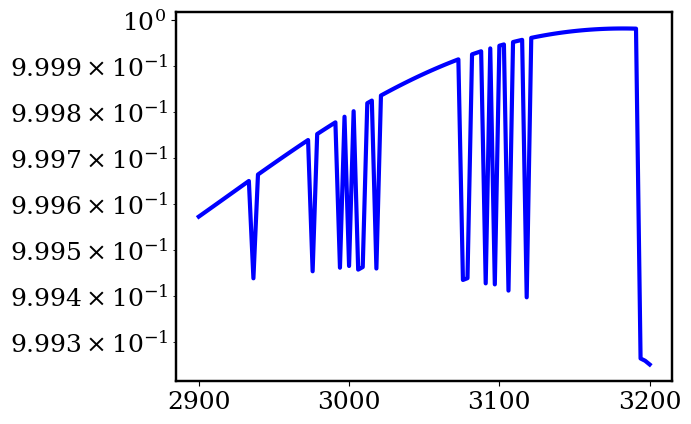

In [ ]:
%matplotlib inline
plt.plot(lambda_tildes, 1-MM, linestyle='-', color='blue')
plt.semilogy()
plt.show()

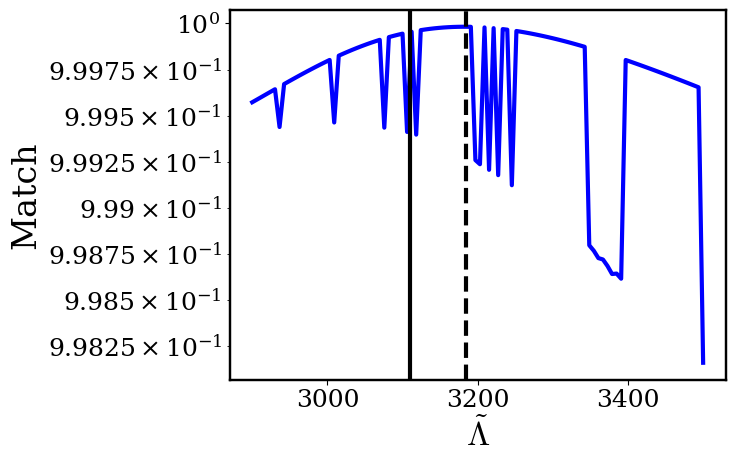

In [ ]:
truelt = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(L1_true, L2_true, 1, 1)

%matplotlib inline
plt.plot(lambda_tildes, 1-MM, linestyle='-', color='blue')
plt.axvline(truelt, color='k', linestyle='-')
plt.axvline(lambda_tildes[np.argmin(MM)], color='k', linestyle='--')
plt.semilogy()
plt.xlabel(r'$\tilde{\Lambda}$')
plt.ylabel('Match')
plt.show()

In [20]:
m1 = 1.4
m2 = 1.4
L1_true = soft_ml_interp(m1).item()
L2_true = soft_ml_interp(m2).item()

In [21]:
laldict = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertFModesFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertUnivRelFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(laldict, L1_true)  
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(laldict, L2_true)  
hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., 1, incl,
0., 0., 0., 0., deltaF, fmin, fmax, fref, laldict, approx)
h_UR = hptilde.data.data - 1j*hctilde.data.data

laldict = lal.CreateDict()

lalsimulation.SimInspiralWaveformParamsInsertFModesFlag(laldict, 2)
lalsimulation.SimInspiralWaveformParamsInsertUnivRelFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(laldict, L1_true)  
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(laldict, L2_true)  
hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., 1, incl,
0., 0., 0., 0., deltaF, fmin, fmax, fref, laldict, approx)
h_true = hptilde.data.data - 1j*hctilde.data.data
freqs = np.arange(0, len(h_UR)*deltaF, deltaF)

In [22]:
phi_UR = np.unwrap(np.angle(h_UR))
phi_true = np.unwrap(np.angle(h_true))

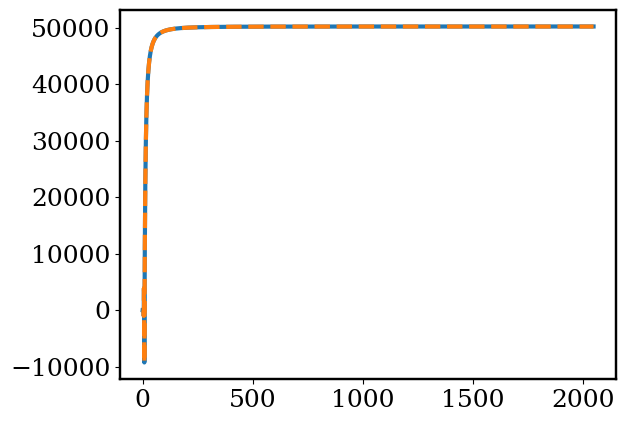

In [23]:
plt.plot(freqs, phi_UR)
plt.plot(freqs, phi_true, linestyle = '--')
plt.show()

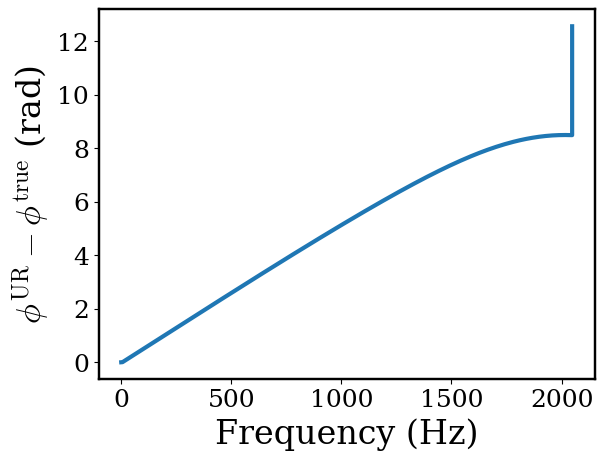

In [24]:
plt.plot(freqs, phi_UR-phi_true)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$ \phi^{\rm UR} - \phi^{\rm true}$ (rad)')
plt.show()

In [25]:
f_UR = get_f2_from_Lambda_UR_SI(L1_true, m1)
print(f_UR)

1882.0065659940853


In [26]:
eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/soft_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]
eos_f = eos_data[:,3]*1000
soft_mf_interp = ius(eos_mass, eos_f)

f_true = soft_mf_interp(m1)
print(f_true)

1890.7465196241378


In [27]:
eos_data[:,3]*1000

array([1479.38 , 1496.904, 1514.175, 1535.618, 1556.279, 1574.978,
       1592.769, 1611.967, 1631.399, 1651.415, 1673.294, 1692.63 ,
       1711.728, 1732.526, 1754.141, 1777.132, 1799.214, 1821.338,
       1843.553, 1866.085, 1888.704, 1911.394, 1934.355, 1957.209,
       1978.86 , 1999.149, 2019.06 , 2038.624, 2057.53 , 2075.748,
       2093.155, 2109.902, 2125.807, 2140.83 , 2154.994, 2168.292,
       2180.759, 2192.457, 2203.145, 2212.883, 2222.026, 2230.769,
       2238.523, 2246.018, 2252.71 , 2259.104, 2265.152, 2270.911,
       2276.277, 2281.396, 2286.217, 2290.93 , 2295.403, 2299.789,
       2304.007, 2308.122, 2312.27 , 2316.513, 2320.728, 2324.935,
       2329.43 , 2334.076, 2338.999, 2343.962, 2348.294, 2352.304,
       2357.329, 2362.659, 2368.073, 2373.509, 2379.451, 2385.17 ,
       2391.094, 2396.823, 2402.586])

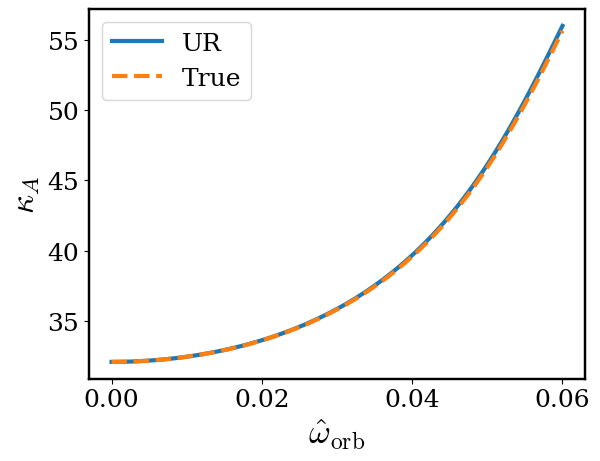

In [28]:
import scipy as sp
M=m1+m2
om1_UR = omega2(L1_true, m1)*M
om2_UR = omega2(L2_true, m2)*M
om1_true = f_true*lal.MTSUN_SI * 2 * np.pi * M
om2_true = om1_true
omega_hat = np.linspace(0,0.12, 1000)
plt.plot(omega_hat/2,kappa_dyn(omega_hat, m1, m2, L1_true, L2_true, om1_UR, om2_UR), label = 'UR')
plt.plot(omega_hat/2,kappa_dyn(omega_hat, m1, m2, L1_true, L2_true, om1_true, om2_true), linestyle = '--', label = 'True')
plt.xlabel(r'$\hat{\omega}_{\mathrm{orb}}$')
plt.ylabel(r'$\kappa_A$')
plt.legend()
plt.show()

In [29]:
omega_hat=np.linspace(0, merger_frequency(m1/M, m2/M,  L1_true, L2_true, 0., 0.),49990)
phiPNdyn_UR = PhiPNdyn(omega_hat, m1, m2, L1_true, L2_true, om1_UR, om2_UR)
phiPNdyn_true = PhiPNdyn(omega_hat, m1, m2, L1_true, L2_true, om1_true, om2_true)
print(om1_UR, om1_true, om2_UR, om2_true)

0.16308295015875351 0.16384030002564243 0.16308295015875351 0.16384030002564243


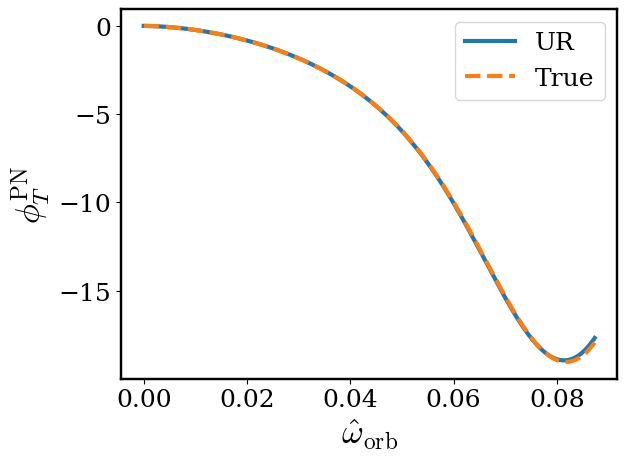

In [30]:
plt.plot(omega_hat/2,phiPNdyn_UR, label = 'UR')
plt.plot(omega_hat/2,phiPNdyn_true, linestyle = '--', label = 'True')
plt.xlabel(r'$\hat{\omega}_{\mathrm{orb}}$')
plt.ylabel(r'$\phi_T^{\rm PN}$')
plt.legend()
plt.show()

In [31]:
psiPN = PsiPN(omega_hat, m1, m2, L1_true, L2_true)
keff_UR = Extract_keff(phiPNdyn_UR.reshape(1, -1), psiPN.reshape(1, -1), omega_hat.reshape(1, -1))
keff_true = Extract_keff(phiPNdyn_true.reshape(1, -1), psiPN.reshape(1, -1), omega_hat.reshape(1, -1))

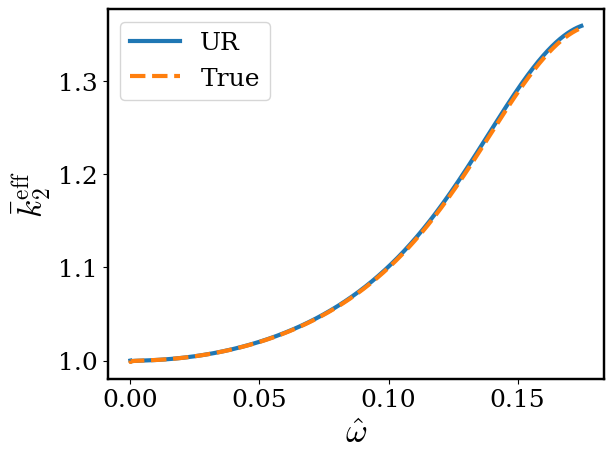

In [32]:
plt.plot(keff_UR[0][0], keff_UR[1][0], label = 'UR')
plt.plot(keff_true[0][0], keff_true[1][0], linestyle = '--', label = 'True')
plt.xlabel(r'$\hat{\omega}}$')
plt.ylabel(r'$\bar{k}_2^{\rm eff}$')
plt.legend()

In [33]:
soft_fit_params = [ 1.22789431e+00,8.43780563e-03 , 1.08070611e-02 , 2.26411246e+01, 2.66341177e-03 ,-2.29058152e-02  ,1.69432184e-01 ,-1.29817652e-04,2.94531211e-04]

In [34]:
fit_k2bar_func(keff_true[0][0], m1/M, m2/M, L1_true, L2_true, soft_fit_params)

array([1.        , 1.00000002, 1.00000005, ..., 1.41070314, 1.41093248,
       1.41116182])

In [35]:
p0 = np.array([1.273000423 ,0.00364169971,0.00176144380,27.8793291,0.0118175396,-0.00539996790,0.142449682,-1.70505852e-5,3.38040594e-5])

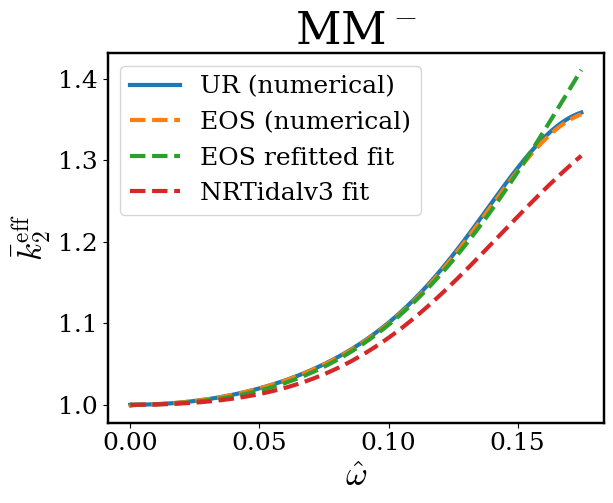

In [36]:
%matplotlib inline
plt.plot(keff_UR[0][0], keff_UR[1][0], label = 'UR (numerical)')
plt.plot(keff_true[0][0], keff_true[1][0], linestyle = '--', label = 'EOS (numerical)')
plt.plot(keff_true[0][0], fit_k2bar_func(keff_true[0][0], m1/M, m2/M, L1_true, L2_true, soft_fit_params), linestyle = '--', label = 'EOS refitted fit')
plt.plot(keff_true[0][0], fit_k2bar_func(keff_true[0][0], m1/M, m2/M, L1_true, L2_true, p0), linestyle = '--', label = 'NRTidalv3 fit')
plt.xlabel(r'$\hat{\omega}}$')
plt.ylabel(r'$\bar{k}_2^{\rm eff}$')
plt.title(r'MM$^-$')
plt.legend()
plt.show()

In [37]:
keff_true[0][0]

array([1.80000000e-05, 6.16749817e-05, 1.05349963e-04, ...,
       1.74586902e-01, 1.74630577e-01, 1.74674252e-01])

# Stiff EOS

In [38]:
m1 = 1.4
m2 = 1.4
L1_true = stiff_ml_interp(m1).item()
L2_true = stiff_ml_interp(m2).item()

In [39]:
laldict = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertFModesFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertUnivRelFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(laldict, L1_true)  
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(laldict, L2_true)  
hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., 1, incl,
0., 0., 0., 0., deltaF, fmin, fmax, fref, laldict, approx)
h_UR = hptilde.data.data - 1j*hctilde.data.data

laldict = lal.CreateDict()

lalsimulation.SimInspiralWaveformParamsInsertFModesFlag(laldict, 3)
lalsimulation.SimInspiralWaveformParamsInsertUnivRelFlag(laldict, 0)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(laldict, L1_true)  
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(laldict, L2_true)  
hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
m1*lal.MSUN_SI, m2*lal.MSUN_SI, 0., 0., 0., 0., 0., 0., 1, incl,
0., 0., 0., 0., deltaF, fmin, fmax, fref, laldict, approx)
h_true = hptilde.data.data - 1j*hctilde.data.data

In [40]:
phi_UR = np.unwrap(np.angle(h_UR))
phi_true = np.unwrap(np.angle(h_true))

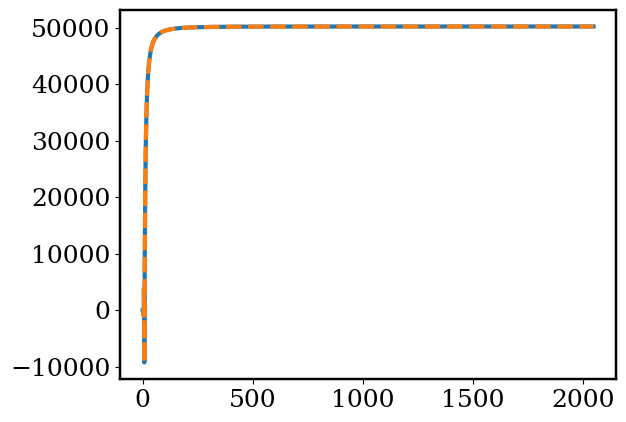

In [41]:
plt.plot(freqs, phi_UR)
plt.plot(freqs, phi_true, linestyle = '--')

Text(0, 0.5, '$ \\phi^{\\rm UR} - \\phi^{\\rm true}$ (rad)')

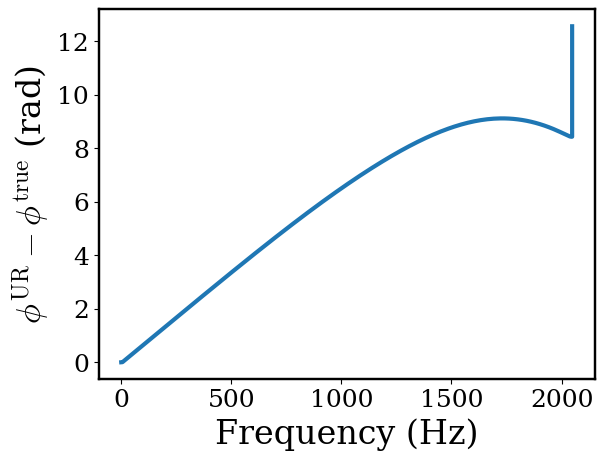

In [42]:
plt.plot(freqs, phi_UR-phi_true)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$ \phi^{\rm UR} - \phi^{\rm true}$ (rad)')

In [43]:
f_UR = get_f2_from_Lambda_UR_SI(L1_true, m1)
print(f_UR)

1619.8905798223827


In [44]:
eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/stiff_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]
eos_f = eos_data[:,3]*1000
soft_mf_interp = ius(eos_mass, eos_f)

f_true = soft_mf_interp(m1)
print(f_true)

1642.5525091156694


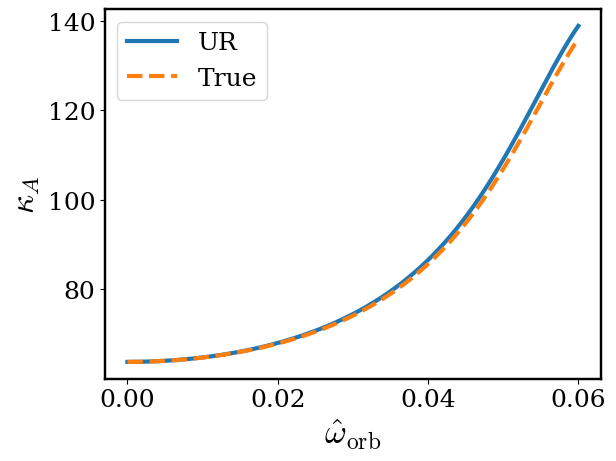

In [45]:
import scipy as sp
M=m1+m2
om1_UR = omega2(L1_true, m1)*M
om2_UR = omega2(L2_true, m2)*M
om1_true = f_true*lal.MTSUN_SI * 2 * np.pi * M
om2_true = om1_true
omega_hat = np.linspace(0,0.12, 1000)
plt.plot(omega_hat/2,kappa_dyn(omega_hat, m1, m2, L1_true, L2_true, om1_UR, om2_UR), label = 'UR')
plt.plot(omega_hat/2,kappa_dyn(omega_hat, m1, m2, L1_true, L2_true, om1_true, om2_true), linestyle = '--', label = 'True')
plt.xlabel(r'$\hat{\omega}_{\mathrm{orb}}$')
plt.ylabel(r'$\kappa_A$')
plt.legend()
plt.show()

In [46]:
omega_hat=np.linspace(0, merger_frequency(m1/M, m2/M,  L1_true, L2_true, 0., 0.),49990)
phiPNdyn_UR = PhiPNdyn(omega_hat, m1, m2, L1_true, L2_true, om1_UR, om2_UR)
phiPNdyn_true = PhiPNdyn(omega_hat, m1, m2, L1_true, L2_true, om1_true, om2_true)
print(m1, m2, L1_true, L2_true, om1_true, om2_true)

1.4 1.4 680.5022909018812 680.5022909018812 0.1423333551632721 0.1423333551632721


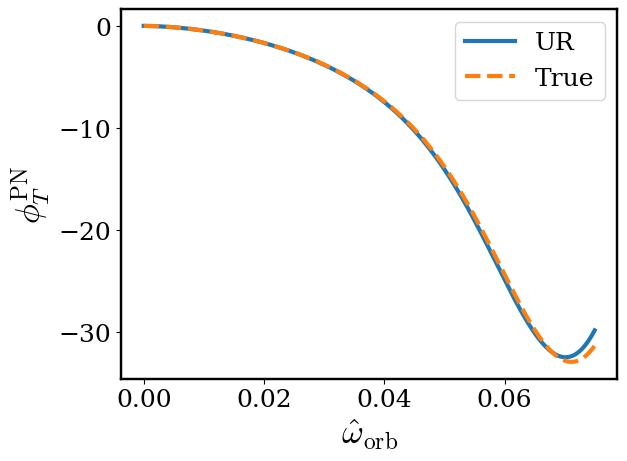

In [47]:
plt.plot(omega_hat/2,phiPNdyn_UR, label = 'UR')
plt.plot(omega_hat/2,phiPNdyn_true, linestyle = '--', label = 'True')
plt.xlabel(r'$\hat{\omega}_{\mathrm{orb}}$')
plt.ylabel(r'$\phi_T^{\rm PN}$')
plt.legend()
plt.show()

In [48]:
psiPN = PsiPN(omega_hat, m1, m2, L1_true, L2_true)
keff_UR = Extract_keff(phiPNdyn_UR.reshape(1, -1), psiPN.reshape(1, -1), omega_hat.reshape(1, -1))
keff_true = Extract_keff(phiPNdyn_true.reshape(1, -1), psiPN.reshape(1, -1), omega_hat.reshape(1, -1))

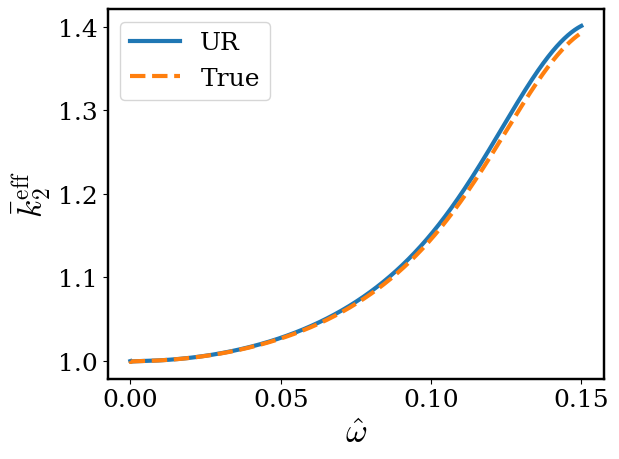

In [49]:
plt.plot(keff_UR[0][0], keff_UR[1][0], label = 'UR')
plt.plot(keff_true[0][0], keff_true[1][0], linestyle = '--', label = 'True')
plt.xlabel(r'$\hat{\omega}}$')
plt.ylabel(r'$\bar{k}_2^{\rm eff}$')
plt.legend()

In [50]:
stiff_fit_params = [ 1.26016532e+00,  9.23850345e-03,  3.07465091e-03,  2.45049251e+01,
        9.75118999e-03, -1.49744133e-02,  1.56750970e-01, -5.14905274e-05,
        1.29091585e-04]

In [51]:
fit_k2bar_func(keff_true[0][0], m1/M, m2/M, L1_true, L2_true, stiff_fit_params)

array([1.        , 1.00000002, 1.00000006, ..., 1.43436625, 1.43463122,
       1.43489624])

In [52]:
p0 = np.array([1.273000423 ,0.00364169971,0.00176144380,27.8793291,0.0118175396,-0.00539996790,0.142449682,-1.70505852e-5,3.38040594e-5])

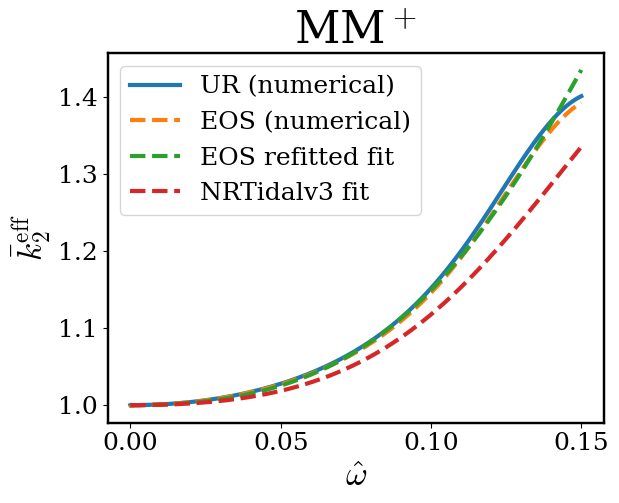

In [53]:
plt.plot(keff_UR[0][0], keff_UR[1][0], label = 'UR (numerical)')
plt.plot(keff_true[0][0], keff_true[1][0], linestyle = '--', label = 'EOS (numerical)')
plt.plot(keff_true[0][0], fit_k2bar_func(keff_true[0][0], m1/M, m2/M, L1_true, L2_true, stiff_fit_params), linestyle = '--', label = 'EOS refitted fit')
plt.plot(keff_true[0][0], fit_k2bar_func(keff_true[0][0], m1/M, m2/M, L1_true, L2_true, p0), linestyle = '--', label = 'NRTidalv3 fit')
plt.xlabel(r'$\hat{\omega}}$')
plt.ylabel(r'$\bar{k}_2^{\rm eff}$')
plt.title(r'MM$^+$')
plt.legend()

## Refitting for URs

In [54]:
eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/soft_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]
eos_om2 = eos_data[:,3] * 1000 * lal.MTSUN_SI * 2 * np.pi

lambda_interp = ius(eos_mass, eos_lambda)
om2_interp = ius(eos_mass, eos_om2)

XAarray=[]
XBarray=[]
LAarray=[]
LBarray=[]
kbareff2_matrix = []
phiTPNmatrix_dyn=[]
psiTPNmatrix_const=[]
omega_hat_array = []
masses = np.linspace(1.0,2.2,10)
for m1 in masses:
    for m2 in masses:
        if m2>m1:
            continue
        else:
            M=m1+m2
            LA =  lambda_interp(m1)
            LB =  lambda_interp(m2)
            omega_hat=np.linspace(0, merger_frequency(m1/M, m2/M, LA, LB, 0., 0.),49990)
            omega_hat_array.append(omega_hat)
            omA = omega2(LA, m1)*M
            omB = omega2(LB, m2)*M
            XAarray.append(m1/M)
            XBarray.append(m2/M)
            LAarray.append(LA)
            LBarray.append(LB)
            phiTPNmatrix_dyn.append(PhiPNdyn(omega_hat, m1, m2, LA, LB, omA, omB))
            psiTPNmatrix_const.append(PsiPN(omega_hat, m1, m2, LA, LB))
kbar_eff=Extract_keff(phiTPNmatrix_dyn, psiTPNmatrix_const, omega_hat_array)

In [55]:
eos_data

array([[1.299565e+01, 8.337704e-01, 9.056165e+03, 1.479380e+00],
       [1.295364e+01, 8.604840e-01, 7.562651e+03, 1.496904e+00],
       [1.291198e+01, 8.869137e-01, 6.349796e+03, 1.514175e+00],
       [1.287182e+01, 9.131203e-01, 5.356380e+03, 1.535618e+00],
       [1.283228e+01, 9.391795e-01, 4.536055e+03, 1.556279e+00],
       [1.279336e+01, 9.651530e-01, 3.853918e+03, 1.574978e+00],
       [1.275479e+01, 9.911088e-01, 3.283100e+03, 1.592769e+00],
       [1.271684e+01, 1.017112e+00, 2.802844e+03, 1.611967e+00],
       [1.267862e+01, 1.043224e+00, 2.396701e+03, 1.631399e+00],
       [1.264102e+01, 1.069514e+00, 2.051934e+03, 1.651415e+00],
       [1.260253e+01, 1.096143e+00, 1.757383e+03, 1.673294e+00],
       [1.256351e+01, 1.123145e+00, 1.504842e+03, 1.692630e+00],
       [1.252422e+01, 1.150636e+00, 1.287602e+03, 1.711728e+00],
       [1.248439e+01, 1.178654e+00, 1.100589e+03, 1.732526e+00],
       [1.244456e+01, 1.207361e+00, 9.393914e+02, 1.754141e+00],
       [1.240447e+01, 1.2

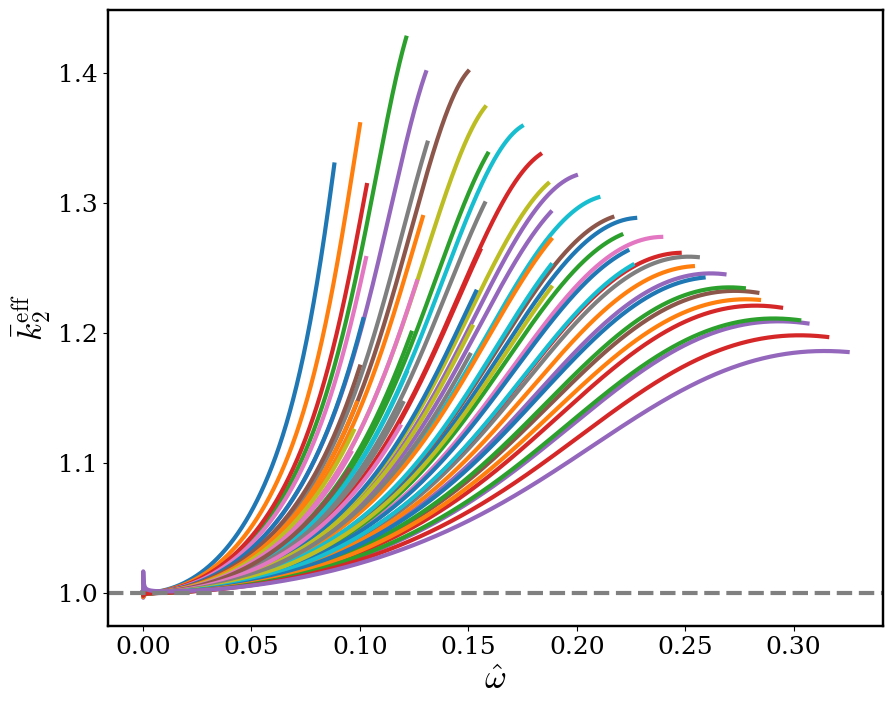

In [56]:
plt.figure(figsize = (10,8))
for i in range(len(XAarray)):
    plt.plot(kbar_eff[0][i,:], kbar_eff[1][i,:])
plt.axhline(1, c='grey', linestyle = '--')
plt.xlabel(r'$\hat{\omega}$')
plt.ylabel(r'$\bar{k}^{\mathrm{eff}}_2$')
plt.show()

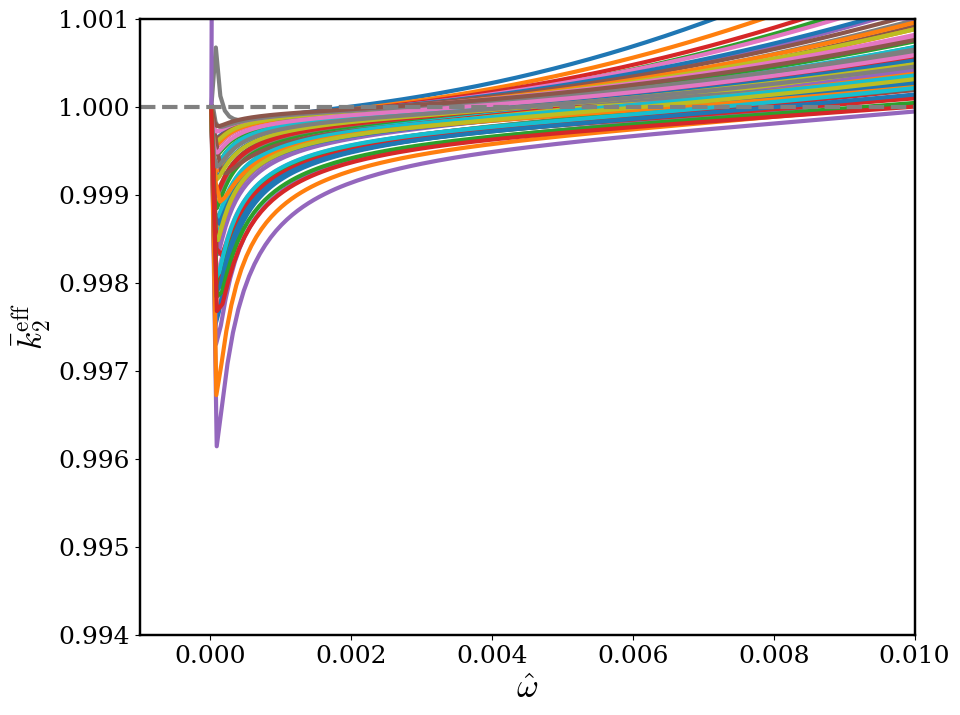

In [57]:
plt.figure(figsize = (10,8))
for i in range(len(XAarray)):
    plt.plot(kbar_eff[0][i,:], kbar_eff[1][i,:])
plt.axhline(1, c='grey', linestyle = '--')
plt.xlabel(r'$\hat{\omega}$')
plt.ylabel(r'$\bar{k}^{\mathrm{eff}}_2$')
plt.xlim(-0.001,0.01 )
plt.ylim(0.994, 1.001)
plt.show()

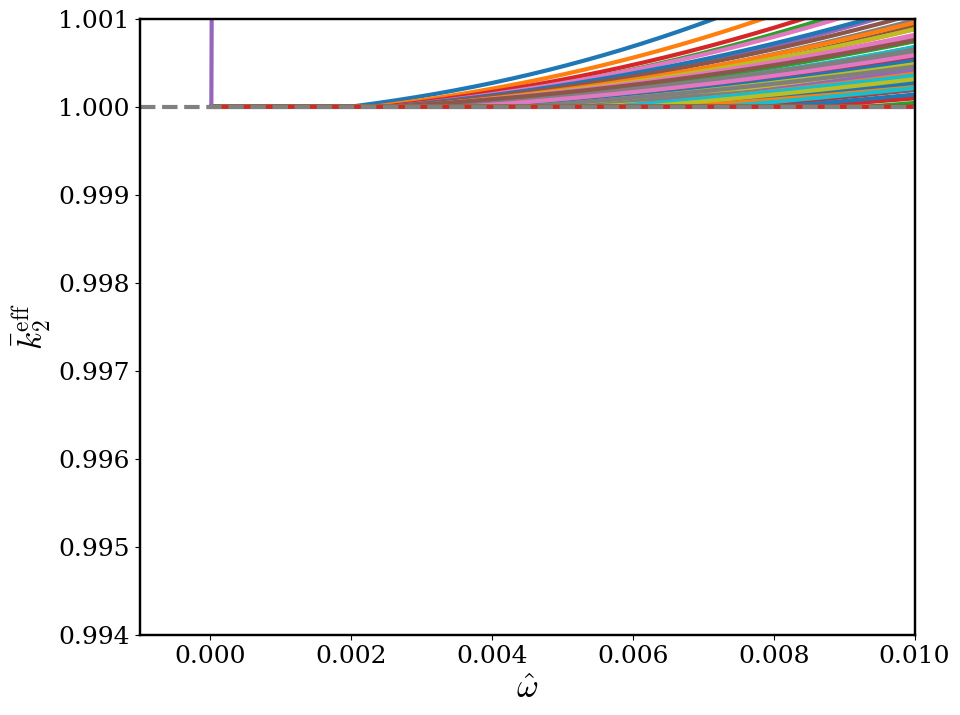

In [58]:
plt.figure(figsize = (10,8))
for i in range(len(XAarray)):
    # mask values where k_eff < 1
    if i<54:
        mask1 = kbar_eff[1][i,1:] < 1
        kbar_eff[1][i,1:][mask1] = 1

        # mask where omega_hat < 0.001
        mask2 = kbar_eff[0][i,1:] < 0.001
        kbar_eff[1][i,1:][mask2] = 1
    plt.plot(kbar_eff[0][i,:], kbar_eff[1][i,:])
plt.axhline(1, c='grey', linestyle = '--')
plt.xlabel(r'$\hat{\omega}$')
plt.ylabel(r'$\bar{k}^{\mathrm{eff}}_2$')
plt.xlim(-0.001,0.01 )
plt.ylim(0.994, 1.001)
plt.show()

In [59]:
# After this, create 
xobs = [kbar_eff[0], XAarray, XBarray,  LAarray, LBarray] ##example
yobs = kbar_eff[1]
p0 = np.array([1.273000423 ,0.00364169971,0.00176144380,27.8793291,0.0118175396,-0.00539996790,0.142449682,-1.70505852e-5,3.38040594e-5])#... (create an array containing your initial guesses)
#Then do
res = sp.optimize.minimize(driver_func, p0, args=(xobs,yobs), options = {'maxiter': 10e10}, tol = 1e-10, method='Nelder-Mead')

#To get the params, just use 
soft_fit_params_UR = res.x
print(res.message)
print(soft_fit_params_UR)

Optimization terminated successfully.
[ 1.22888589e+00  9.50882199e-03  9.65368361e-03  2.27922788e+01
 -2.71976632e-02  5.04110355e-03  1.68684198e-01 -3.01234467e-05
  1.92703517e-04]


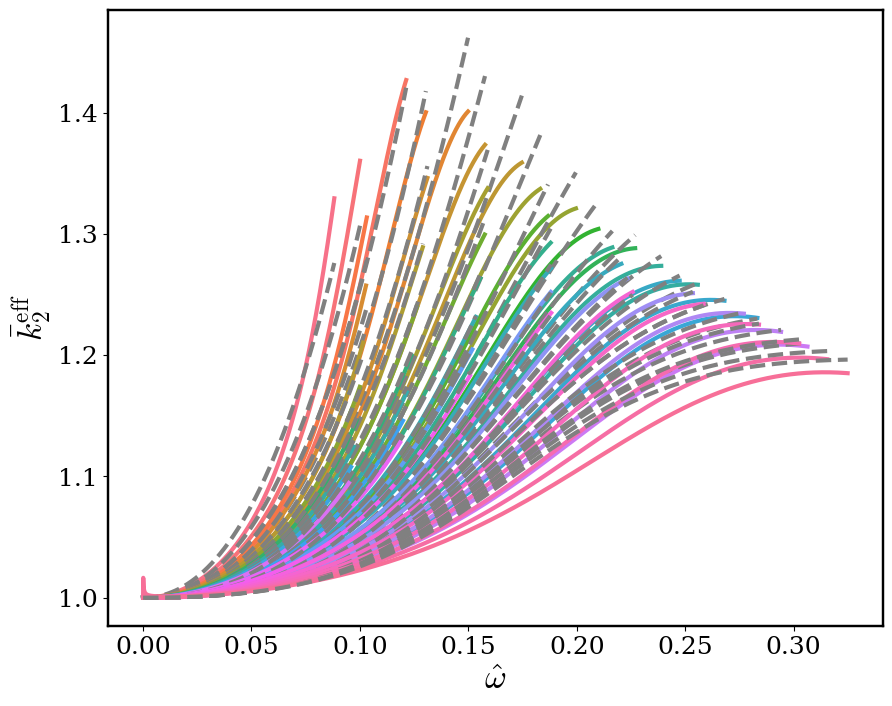

In [60]:
c = sns.husl_palette(len(XAarray))
plt.figure(figsize = (10,8))
for i in range(len(XAarray)):
    plt.plot(kbar_eff[0][i,:], kbar_eff[1][i,:], c = c[i])
    plt.plot(kbar_eff[0][i,:], fit_k2bar_func(kbar_eff[0][i,:], XAarray[i], XBarray[i], LAarray[i], LBarray[i], soft_fit_params_UR), linestyle = '--', c = 'grey')
    #plt.plot(kbar_eff[0][i,:], fit_k2bar_func(kbar_eff[0][i,:], XAarray[i], XBarray[i], LAarray[i], LBarray[i], p0),  c = c[i],linestyle = '-.')
#plt.axhline(1, c='grey', linestyle = '--')
plt.xlabel(r'$\hat{\omega}$')
plt.ylabel(r'$\bar{k}^{\mathrm{eff}}_2$')
plt.show()

## Comparisons

In [61]:
m1 = 1.4
m2 = 1.4
M=m1+m2

eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/soft_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]
eos_om2 = eos_data[:,3] * 1000 * lal.MTSUN_SI * 2 * np.pi

lambda_interp = ius(eos_mass, eos_lambda)
om2_interp = ius(eos_mass, eos_om2)

L1_soft = lambda_interp(m1).item()
L2_soft = lambda_interp(m2).item()

om1_UR = omega2(L1_soft, m1)*M
om2_UR = omega2(L2_soft, m2)*M
om1_soft = om2_interp(m1) * M
om2_soft = om2_interp(m2) * M

omega_hat=np.linspace(0, merger_frequency(m1/M, m2/M,  L1_soft, L2_soft, 0., 0.),49990)
phiPNdyn_UR = PhiPNdyn(omega_hat, m1, m2, L1_soft, L2_soft, om1_UR, om2_UR)
phiPNdyn_soft = PhiPNdyn(omega_hat, m1, m2, L1_soft, L2_soft, om1_soft, om2_soft)

psiPN_soft = PsiPN(omega_hat, m1, m2, L1_soft, L2_soft)
keff_soft_UR = Extract_keff(phiPNdyn_UR.reshape(1, -1), psiPN_soft.reshape(1, -1), omega_hat.reshape(1, -1))
keff_soft = Extract_keff(phiPNdyn_soft.reshape(1, -1), psiPN_soft.reshape(1, -1), omega_hat.reshape(1, -1))

soft_fit_params = [ 1.22789431e+00,8.43780563e-03 , 1.08070611e-02 , 2.26411246e+01, 2.66341177e-03 ,-2.29058152e-02  ,1.69432184e-01 ,-1.29817652e-04,2.94531211e-04]
stiff_fit_params = [ 1.26016532e+00,  9.23850345e-03,  3.07465091e-03,  2.45049251e+01,9.75118999e-03, -1.49744133e-02,  1.56750970e-01, -5.14905274e-05, 1.29091585e-04]

In [62]:
eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/stiff_mrlfmode.dat')
eos_mass = eos_data[:,1]
eos_lambda = eos_data[:,2]
eos_om2 = eos_data[:,3] * 1000 * lal.MTSUN_SI * 2 * np.pi

lambda_interp = ius(eos_mass, eos_lambda)
om2_interp = ius(eos_mass, eos_om2)

L1_stiff = lambda_interp(m1).item()
L2_stiff = lambda_interp(m2).item()

om1_UR = omega2(L1_stiff, m1)*M
om2_UR = omega2(L2_stiff, m2)*M
om1_stiff = om2_interp(m1) * M
om2_stiff = om2_interp(m2) * M

omega_hat=np.linspace(0, merger_frequency(m1/M, m2/M,  L1_stiff, L2_stiff, 0., 0.),49990)
phiPNdyn_UR = PhiPNdyn(omega_hat, m1, m2, L1_stiff, L2_stiff, om1_UR, om2_UR)
phiPNdyn_stiff = PhiPNdyn(omega_hat, m1, m2, L1_stiff, L2_stiff, om1_stiff, om2_stiff)

psiPN_stiff = PsiPN(omega_hat, m1, m2, L1_stiff, L2_stiff)
keff_stiff_UR = Extract_keff(phiPNdyn_UR.reshape(1, -1), psiPN_stiff.reshape(1, -1), omega_hat.reshape(1, -1))
keff_stiff = Extract_keff(phiPNdyn_stiff.reshape(1, -1), psiPN_stiff.reshape(1, -1), omega_hat.reshape(1, -1))

In [63]:
soft_fit_params_UR = [ 1.22827517e+00,  8.20111996e-03,  1.08501483e-02,  2.28304860e+01,
        1.24936985e-03, -2.09458222e-02,  1.68708968e-01, -1.18521922e-04,
        2.73745415e-04]

stiff_fit_params_UR = [ 1.26318668e+00,  8.74584407e-03,  3.31920278e-03,  2.48354839e+01,
        8.85295938e-03, -1.09442546e-02,  1.55265748e-01, -5.35049515e-05,
        1.14110940e-04]

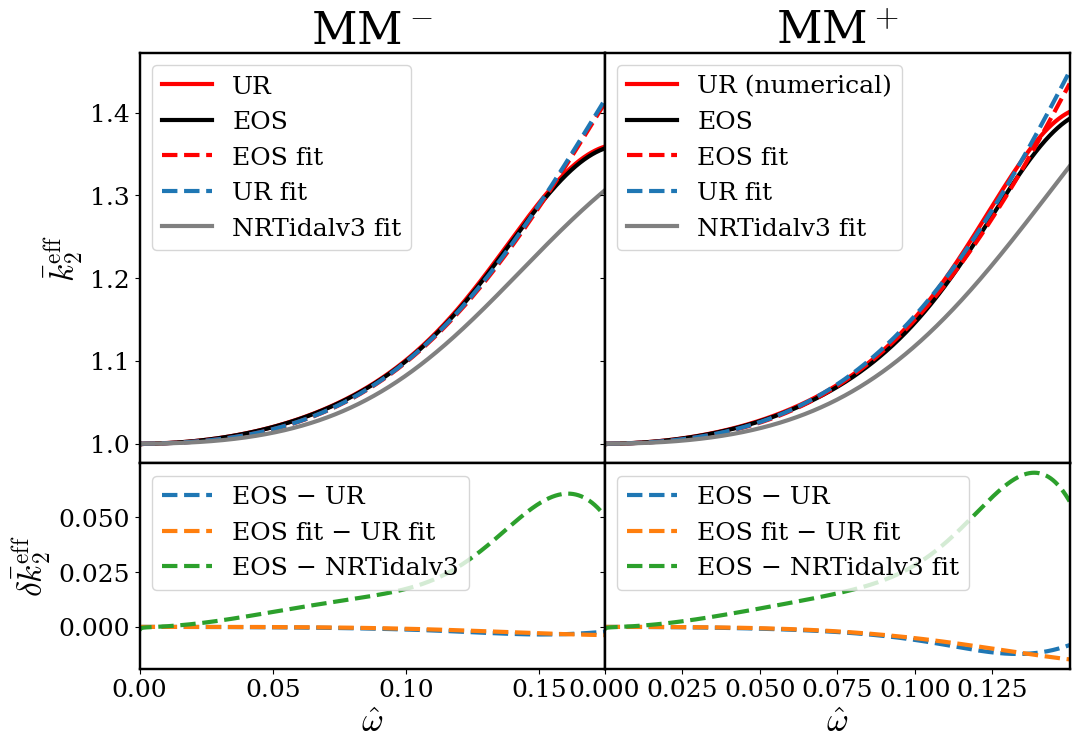

In [64]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.0, wspace=0.)

# ================================================================
# Create the subplots WITH sharing structure
# ================================================================

# Left column (soft)
ax_soft_main = fig.add_subplot(gs[0, 0])
ax_soft_diff = fig.add_subplot(gs[1, 0], sharex=ax_soft_main)   # share x with soft top
ax_soft_main.set_xlim(0, keff_soft[0][0][-1])
ax_soft_diff.set_xlim(0, keff_soft[0][0][-1])
# Right column (stiff)
ax_stiff_main = fig.add_subplot(gs[0, 1], sharey=ax_soft_main)  # share y with soft top
ax_stiff_diff = fig.add_subplot(gs[1, 1], sharex=ax_stiff_main, sharey=ax_soft_diff)
ax_stiff_main.set_xlim(0, keff_stiff[0][0][-1])
ax_stiff_diff.set_xlim(0, keff_stiff[0][0][-1])
# ================================================================
# SOFT — TOP LEFT
# ================================================================
ax_soft_main.plot(keff_soft_UR[0][0], keff_soft_UR[1][0], label='UR', linestyle='-', color = 'red')
ax_soft_main.plot(keff_soft[0][0], keff_soft[1][0], linestyle='-', label='EOS', color = 'k')
ax_soft_main.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params),
                  linestyle='--', label='EOS fit', color = 'red')
ax_soft_main.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params_UR),
                  linestyle='--', label='UR fit')
ax_soft_main.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, p0),
                  linestyle='-', label='NRTidalv3 fit', color = 'grey')

ax_soft_main.set_title(r"MM$^-$")
ax_soft_main.legend()

# ================================================================
# SOFT — BOTTOM LEFT
# ================================================================
ax_soft_diff.plot(keff_soft[0][0],
                  keff_soft[1][0] - keff_soft_UR[1][0], linestyle='--', label='EOS − UR')
ax_soft_diff.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M,
                                 L1_soft, L2_soft, soft_fit_params) -
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M,
                                 L1_soft, L2_soft, soft_fit_params_UR),
                  linestyle='--', label='EOS fit − UR fit')
ax_soft_diff.plot(keff_soft[0][0],
                  keff_soft[1][0] -
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M,
                                 L1_soft, L2_soft, p0),
                  linestyle='--', label='EOS − NRTidalv3')

ax_soft_diff.legend()

# ================================================================
# STIFF — TOP RIGHT  (shares y-axis with soft top)
# ================================================================
ax_stiff_main.plot(keff_stiff_UR[0][0], keff_stiff_UR[1][0], label='UR (numerical)', linestyle='-', color = 'red')
ax_stiff_main.plot(keff_stiff[0][0], keff_stiff[1][0], linestyle='-', label='EOS', color = 'k')
ax_stiff_main.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M,
                                  L1_stiff, L2_stiff, stiff_fit_params),
                   linestyle='--', label='EOS fit', color = 'red')
ax_stiff_main.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M,
                                  L1_stiff, L2_stiff, stiff_fit_params_UR),
                   linestyle='--', label='UR fit')
ax_stiff_main.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M,
                                  L1_stiff, L2_stiff, p0),
                   linestyle='-', label='NRTidalv3 fit', color = 'grey')

ax_stiff_main.set_title(r"MM$^+$")
ax_stiff_main.legend()

# ================================================================
# STIFF — BOTTOM RIGHT (shares x with stiff top and y with soft bottom)
# ================================================================
ax_stiff_diff.plot(keff_stiff[0][0],
                   keff_stiff[1][0] - keff_stiff_UR[1][0],
                   linestyle='--', label='EOS − UR')
ax_stiff_diff.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M,
                                  L1_stiff, L2_stiff, stiff_fit_params) -
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M,
                                  L1_stiff, L2_stiff, stiff_fit_params_UR),
                   linestyle='--', label='EOS fit − UR fit')
ax_stiff_diff.plot(keff_stiff[0][0],
                   keff_stiff[1][0] -
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M,
                                  L1_stiff, L2_stiff, p0),
                   linestyle='--', label='EOS − NRTidalv3 fit')

ax_stiff_diff.legend()

ax_stiff_diff.set_xlabel(r'$\hat{\omega}}$')
ax_soft_diff.set_xlabel(r'$\hat{\omega}}$')
ax_soft_main.set_ylabel(r'$\bar{k}_2^{\rm eff}$')
ax_soft_diff.set_ylabel(r'$\delta \bar{k}_2^{\rm eff}$')

# Reduce clutter (hide duplicated tick labels)
plt.setp(ax_soft_main.get_xticklabels(), visible=False)
plt.setp(ax_stiff_main.get_xticklabels(), visible=False)
plt.setp(ax_stiff_main.get_yticklabels(), visible=False)
plt.setp(ax_stiff_diff.get_yticklabels(), visible=False)

plt.show()

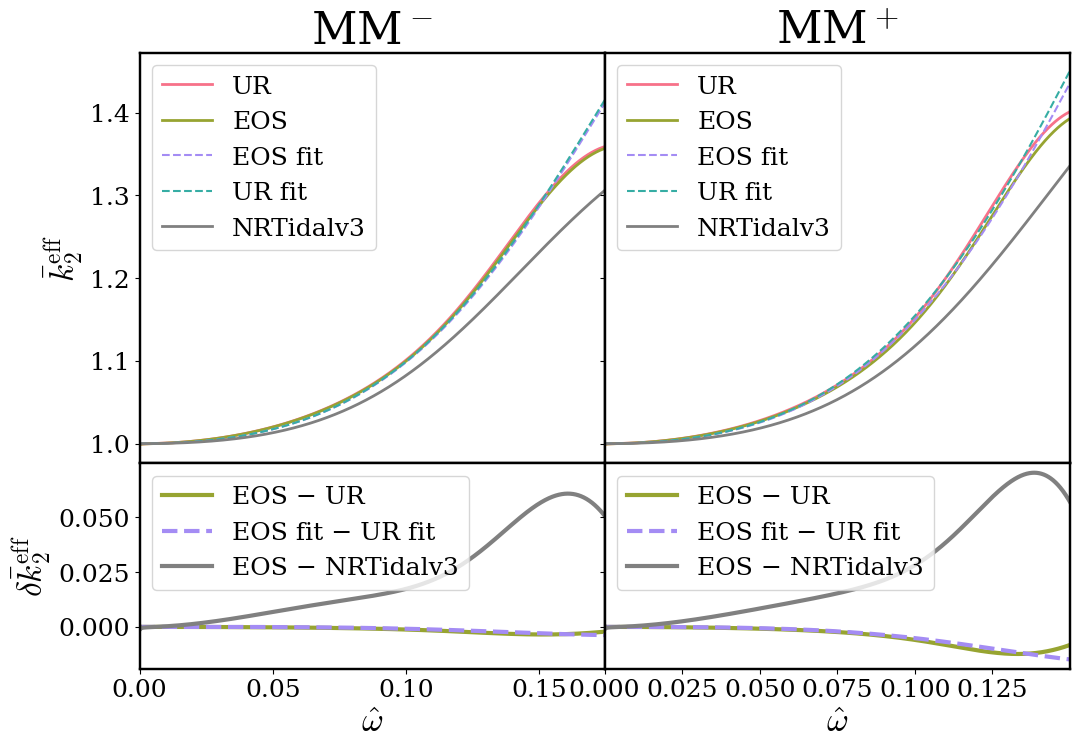

In [65]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Get 5 husl colors
colors = sns.color_palette("husl", 4)
color_UR_num = colors[0]     # UR numerical
color_EOS_num = colors[1]    # EOS numerical
color_UR_fit = colors[2]     # UR fit
color_EOS_fit = colors[3]    # EOS fit
color_NRT = colors[0]        # NRTidalv3 fit (or we can override to grey)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.0, wspace=0.)

# -------------------------
# Subplots
# -------------------------
ax_soft_main = fig.add_subplot(gs[0, 0])
ax_soft_diff = fig.add_subplot(gs[1, 0], sharex=ax_soft_main)
ax_soft_main.set_xlim(0, keff_soft[0][0][-1])
ax_soft_diff.set_xlim(0, keff_soft[0][0][-1])

ax_stiff_main = fig.add_subplot(gs[0, 1], sharey=ax_soft_main)
ax_stiff_diff = fig.add_subplot(gs[1, 1], sharex=ax_stiff_main, sharey=ax_soft_diff)
ax_stiff_main.set_xlim(0, keff_stiff[0][0][-1])
ax_stiff_diff.set_xlim(0, keff_stiff[0][0][-1])

# -------------------------
# SOFT — TOP LEFT
# -------------------------
ax_soft_main.plot(keff_soft_UR[0][0], keff_soft_UR[1][0], label='UR', color=color_UR_num, linestyle='-', lw=2)
ax_soft_main.plot(keff_soft[0][0], keff_soft[1][0], label='EOS', color=color_EOS_num, linestyle='-', lw=2)
ax_soft_main.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params),
                  label='EOS fit', color=color_EOS_fit, linestyle='--', lw=1.5)
ax_soft_main.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params_UR),
                  label='UR fit', color=color_UR_fit, linestyle='--', lw=1.5)
ax_soft_main.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, p0),
                  label='NRTidalv3', color='grey', linestyle='-', lw=2)

ax_soft_main.set_title(r"MM$^-$")
ax_soft_main.legend()

# -------------------------
# SOFT — BOTTOM LEFT
# -------------------------
ax_soft_diff.plot(keff_soft[0][0],
                  keff_soft[1][0] - keff_soft_UR[1][0], linestyle='-', color=color_EOS_num, label='EOS − UR')
ax_soft_diff.plot(keff_soft[0][0],
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params) -
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params_UR),
                  linestyle='--', color=color_EOS_fit, label='EOS fit − UR fit')
ax_soft_diff.plot(keff_soft[0][0],
                  keff_soft[1][0] -
                  fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, p0),
                  linestyle='-', color='grey', label='EOS − NRTidalv3')
ax_soft_diff.legend()

# -------------------------
# STIFF — TOP RIGHT
# -------------------------
ax_stiff_main.plot(keff_stiff_UR[0][0], keff_stiff_UR[1][0], label='UR', color=color_UR_num, linestyle='-', lw=2)
ax_stiff_main.plot(keff_stiff[0][0], keff_stiff[1][0], label='EOS', color=color_EOS_num, linestyle='-', lw=2)
ax_stiff_main.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, stiff_fit_params),
                   label='EOS fit', color=color_EOS_fit, linestyle='--', lw=1.5)
ax_stiff_main.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, stiff_fit_params_UR),
                   label='UR fit', color=color_UR_fit, linestyle='--', lw=1.5)
ax_stiff_main.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, p0),
                   label='NRTidalv3', color='grey', linestyle='-', lw=2)
ax_stiff_main.set_title(r"MM$^+$")
ax_stiff_main.legend()

# -------------------------
# STIFF — BOTTOM RIGHT
# -------------------------
ax_stiff_diff.plot(keff_stiff[0][0],
                   keff_stiff[1][0] - keff_stiff_UR[1][0], linestyle='-', color=color_EOS_num, label='EOS − UR')
ax_stiff_diff.plot(keff_stiff[0][0],
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, stiff_fit_params) -
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, stiff_fit_params_UR),
                   linestyle='--', color=color_EOS_fit, label='EOS fit − UR fit')
ax_stiff_diff.plot(keff_stiff[0][0],
                   keff_stiff[1][0] -
                   fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, p0),
                   linestyle='-', color='grey', label='EOS − NRTidalv3')
ax_stiff_diff.legend()

# -------------------------
# Labels
# -------------------------
ax_stiff_diff.set_xlabel(r'$\hat{\omega}$')
ax_soft_diff.set_xlabel(r'$\hat{\omega}$')
ax_soft_main.set_ylabel(r'$\bar{k}_2^{\rm eff}$')
ax_soft_diff.set_ylabel(r'$\delta \bar{k}_2^{\rm eff}$')

# Reduce clutter (hide duplicated tick labels)
plt.setp(ax_soft_main.get_xticklabels(), visible=False)
plt.setp(ax_stiff_main.get_xticklabels(), visible=False)
plt.setp(ax_stiff_main.get_yticklabels(), visible=False)
plt.setp(ax_stiff_diff.get_yticklabels(), visible=False)

plt.show()


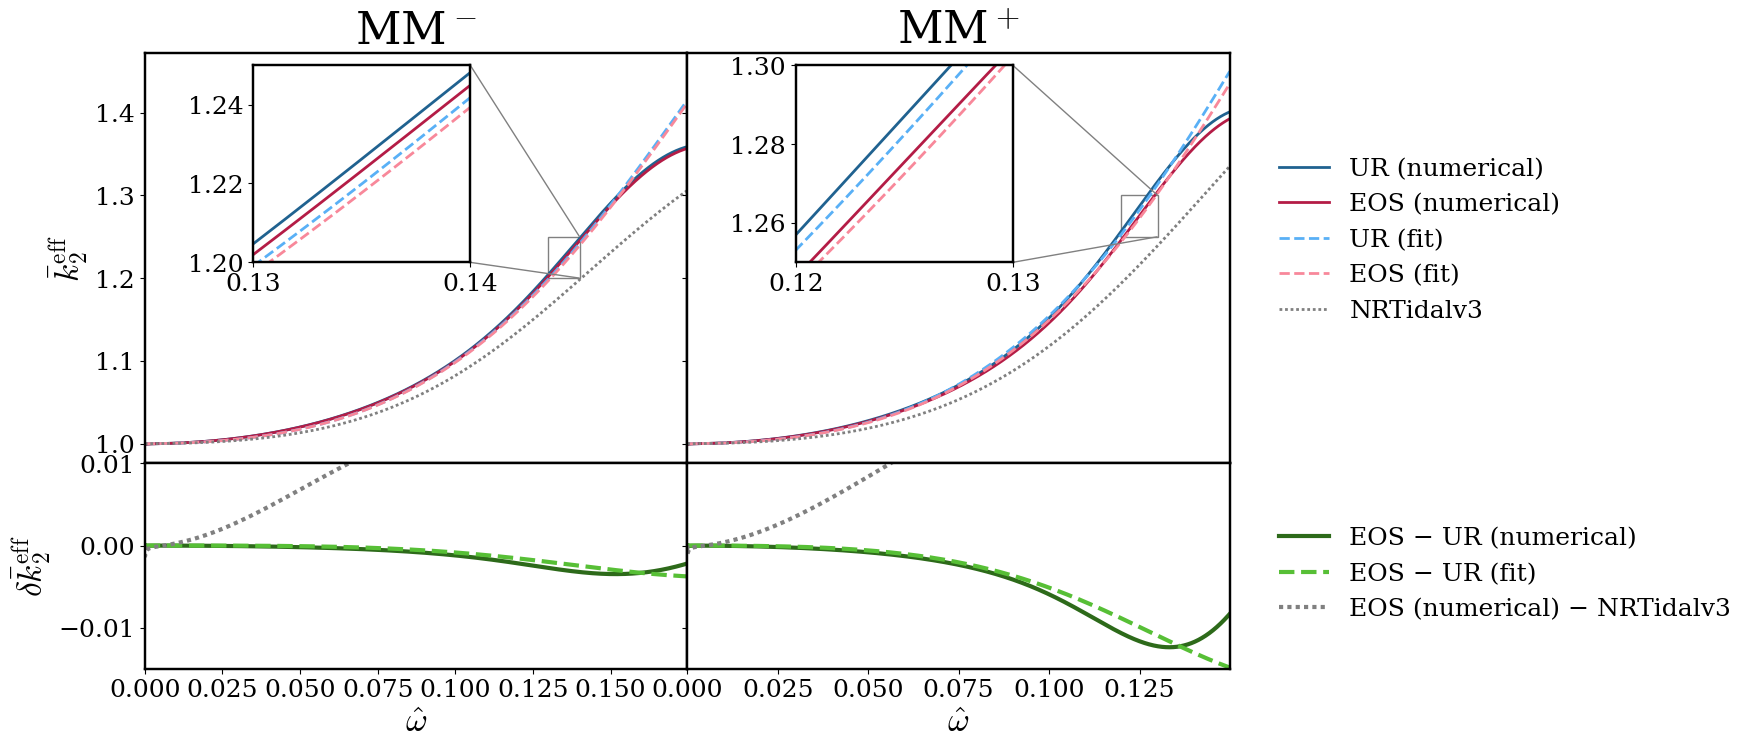

In [66]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Husl colors
colors_light = sns.husl_palette(3, l=0.7)
colors_dark = sns.husl_palette(3, l=0.4)
color_UR_num = colors_dark[2]  
color_EOS_num = colors_dark[0]  
color_UR_fit = colors_light[2]    
color_EOS_fit = colors_light[0]   
color_NRT = 'grey'       

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.0, wspace=0.)

# -------------------------
# Subplots
# -------------------------
ax_soft_main = fig.add_subplot(gs[0, 0])
ax_soft_diff = fig.add_subplot(gs[1, 0], sharex=ax_soft_main)
ax_stiff_main = fig.add_subplot(gs[0, 1], sharey=ax_soft_main)
ax_stiff_diff = fig.add_subplot(gs[1, 1], sharex=ax_stiff_main, sharey=ax_soft_diff)

# Set x-limits
ax_soft_main.set_xlim(0, keff_soft[0][0][-1])
ax_soft_diff.set_xlim(0, keff_soft[0][0][-1])
ax_stiff_main.set_xlim(0, keff_stiff[0][0][-1])
ax_stiff_diff.set_xlim(0, keff_stiff[0][0][-1])

# -------------------------
# PLOT FUNCTION (top panels)
# -------------------------
def plot_top(ax, keff_UR, keff_EOS, L1, L2, fit_params, fit_params_UR):
    ax.plot(keff_UR[0][0], keff_UR[1][0], label='UR (numerical)', color=color_UR_num, linestyle='-', lw=2)
    ax.plot(keff_EOS[0][0], keff_EOS[1][0], label='EOS (numerical)', color=color_EOS_num, linestyle='-', lw=2)
    ax.plot(keff_EOS[0][0],
            fit_k2bar_func(keff_EOS[0][0], m1/M, m2/M, L1, L2, fit_params_UR),
            label='UR (fit)', color=color_UR_fit, linestyle='--', lw=2)
    ax.plot(keff_EOS[0][0],
            fit_k2bar_func(keff_EOS[0][0], m1/M, m2/M, L1, L2, fit_params),
            label='EOS (fit)', color=color_EOS_fit, linestyle='--', lw=2)
    ax.plot(keff_EOS[0][0],
            fit_k2bar_func(keff_EOS[0][0], m1/M, m2/M, L1, L2, p0),
            label='NRTidalv3', color='grey', linestyle=(0, (1, 1)), lw=2)

plot_top(ax_soft_main, keff_soft_UR, keff_soft, L1_soft, L2_soft, soft_fit_params, soft_fit_params_UR)
plot_top(ax_stiff_main, keff_stiff_UR, keff_stiff, L1_stiff, L2_stiff, stiff_fit_params, stiff_fit_params_UR)

ax_soft_main.set_title(r"MM$^-$")
ax_stiff_main.set_title(r"MM$^+$")

# -------------------------
# Bottom panels (differences)
# -------------------------
def plot_diff(ax, keff_UR, keff_EOS, L1, L2, fit_params, fit_params_UR):
    ax.plot(keff_EOS[0][0],
            keff_EOS[1][0] - keff_UR[1][0], linestyle='-', color=colors_dark[1], label='EOS − UR (numerical)')
    ax.plot(keff_EOS[0][0],
            fit_k2bar_func(keff_EOS[0][0], m1/M, m2/M, L1, L2, fit_params) -
            fit_k2bar_func(keff_EOS[0][0], m1/M, m2/M, L1, L2, fit_params_UR),
            linestyle='--', color=colors_light[1], label='EOS − UR (fit)')
    ax.plot(keff_EOS[0][0],
            keff_EOS[1][0] -
            fit_k2bar_func(keff_EOS[0][0], m1/M, m2/M, L1, L2, p0),
            linestyle=(0, (1, 1)), color='grey', label='EOS (numerical) − NRTidalv3')
    ax.set_ylim(-0.015, 0.01)

plot_diff(ax_soft_diff, keff_soft_UR, keff_soft, L1_soft, L2_soft, soft_fit_params, soft_fit_params_UR)
plot_diff(ax_stiff_diff, keff_stiff_UR, keff_stiff, L1_stiff, L2_stiff, stiff_fit_params, stiff_fit_params_UR)

# -------------------------
# Zoom-in (inset axes)
# -------------------------
# Soft top-left zoom
axins_soft = inset_axes(ax_soft_main, width="40%", height="40%", loc='upper center', bbox_to_anchor=(-0.1, -0.2,1.0, 1.2), bbox_transform=ax_soft_main.transAxes)
axins_soft.plot(keff_soft_UR[0][0], keff_soft_UR[1][0], color=color_UR_num, linestyle='-', lw=2)
axins_soft.plot(keff_soft[0][0], keff_soft[1][0], color=color_EOS_num, linestyle='-', lw=2)
axins_soft.plot(keff_soft[0][0],
                fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params),
                color=color_EOS_fit, linestyle='--', lw=2)
axins_soft.plot(keff_soft[0][0],
                fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, soft_fit_params_UR),
                color=color_UR_fit, linestyle='--', lw=2)
axins_soft.plot(keff_soft[0][0],
                fit_k2bar_func(keff_soft[0][0], m1/M, m2/M, L1_soft, L2_soft, p0),
                color='grey', linestyle='-', lw=2)
axins_soft.set_xlim(0.13, 0.14)
axins_soft.set_ylim(1.2, 1.25)
mark_inset(ax_soft_main, axins_soft, loc1=1, loc2=4, fc="none", ec="0.5")

# Stiff top-right zoom
axins_stiff = inset_axes(ax_stiff_main, width="40%", height="40%", loc='upper center', bbox_to_anchor=(-0.1, -0.2,1.0, 1.2), bbox_transform=ax_stiff_main.transAxes)
axins_stiff.plot(keff_stiff_UR[0][0], keff_stiff_UR[1][0], color=color_UR_num, linestyle='-', lw=2)
axins_stiff.plot(keff_stiff[0][0], keff_stiff[1][0], color=color_EOS_num, linestyle='-', lw=2)
axins_stiff.plot(keff_stiff[0][0],
                 fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, stiff_fit_params),
                 color=color_EOS_fit, linestyle='--', lw=2)
axins_stiff.plot(keff_stiff[0][0],
                 fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, stiff_fit_params_UR),
                 color=color_UR_fit, linestyle='--', lw=2)
axins_stiff.plot(keff_stiff[0][0],
                 fit_k2bar_func(keff_stiff[0][0], m1/M, m2/M, L1_stiff, L2_stiff, p0),
                 color='grey', linestyle='-', lw=2)
axins_stiff.set_xlim(0.12, 0.13)
axins_stiff.set_ylim(1.25, 1.3)
mark_inset(ax_stiff_main, axins_stiff, loc1=1, loc2=4, fc="none", ec="0.5")

# -------------------------
# Labels
# -------------------------
ax_soft_diff.set_xlabel(r'$\hat{\omega}$')
ax_stiff_diff.set_xlabel(r'$\hat{\omega}$')
ax_soft_main.set_ylabel(r'$\bar{k}_2^{\rm eff}$')
ax_soft_diff.set_ylabel(r'$\delta \bar{k}_2^{\rm eff}$')

# -------------------------
# Legends outside
# -------------------------
#ax_soft_main.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax_stiff_main.legend(loc='upper left', bbox_to_anchor=(1.05, 0.8), frameon=False)
#ax_soft_diff.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax_stiff_diff.legend(loc='upper left', bbox_to_anchor=(1.05, 0.8), frameon=False)

# Reduce clutter (hide duplicated tick labels)
plt.setp(ax_soft_main.get_xticklabels(), visible=False)
plt.setp(ax_stiff_main.get_xticklabels(), visible=False)
plt.setp(ax_stiff_main.get_yticklabels(), visible=False)
plt.setp(ax_stiff_diff.get_yticklabels(), visible=False)
plt.savefig('keff_comparisons.pdf', bbox_inches='tight', dpi = 600)
plt.show()
